# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: 18 марта 00:00

Мягкий дедлайн: 1 апреля 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet. 

Ссылка на данные: https://yadi.sk/d/-ug82uwhSuLYrA

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

from torch import optim
import zipfile
import os

from google.colab import drive
from PIL import Image, ImageEnhance

import natsort

import glob

import joblib
from joblib import Parallel, delayed

from tqdm.notebook import tqdm
from IPython.display import clear_output

from skimage.morphology import area_closing, area_opening

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        self.images_dir = images_dir
        self.target_dir = target_dir

        self.transforms = transforms

        self.images = self.make_dataset(self.images_dir)
        self.target = self.make_dataset(self.target_dir)

    def make_dataset(self, dir):
        num_of_cpu = joblib.cpu_count()
        delayed_funcs = [delayed(Image.open)(file) for file in natsort.natsorted(glob.glob(dir+'/*'))]
        parallel_pool = Parallel(n_jobs=num_of_cpu)
        dataset = parallel_pool(delayed_funcs)
        return dataset

    def __len__(self):
        return len(self.images)
                   
    def __getitem__(self, idx):
        image, mask = self.images[idx], self.target[idx]
        sample = {'image': image, 'mask': mask}

        if self.transforms:
            sample = self.transforms(sample)

        return sample

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [4]:
class Compose():

    def __init__(self, *transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

class RandomHorizontalFlip():

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):

        image, mask = sample['image'], sample['mask']

        if torch.rand(1) < self.p:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        return {'image': image, 'mask': mask}
        

class RandomErasing():

    def __init__(self, p=0.5, shape=None):
        self.p = p
        self.shape = shape

    def __call__(self, sample):

        image, mask = sample['image'], sample['mask']

        if torch.rand(1) < self.p:

            image, mask = np.asarray(image).copy(), np.asarray(mask).copy()

            i_w, i_h = image.shape[:2]

            if self.shape is None:
                self.shape = (np.random.randint(i_h), 
                              np.random.randint(i_w)) 
            else:
                self.shape = np.clip(self.shape, [1, 1], [i_h-1, i_w-1])
                
            point = (np.random.randint(i_h-self.shape[0]), 
                    np.random.randint(i_w-self.shape[1]))

            image[point[0]:point[0]+self.shape[0], 
                  point[1]:point[1]+self.shape[1]] = [0, 0, 0]

            mask[point[0]:point[0]+self.shape[0], 
                  point[1]:point[1]+self.shape[1]] = 0

            image = Image.fromarray(np.uint8(image))
            mask = Image.fromarray(np.uint8(mask))

        return {'image': image, 'mask': mask}


class RandomAdjustBrightness():

    def __init__(self, p=0.5, brightness_factor=None):
        self.p = p
        self.brightness_factor = brightness_factor

    def __call__(self, sample):

        image, mask = sample['image'], sample['mask']

        if torch.rand(1) < self.p:
            if self.brightness_factor is None:
                self.brightness_factor = np.random.rand(1)

            else:
                self.brightness_factor = np.clip(self.brightness_factor, 0, 1) 

            enhancer = ImageEnhance.Brightness(image)
            image = enhancer.enhance(self.brightness_factor)

        return {'image': image, 'mask': mask}


class RandomReplaceBackground():

    def __init__(self, backgrounds, p=0.5):
        self.p = p
        self.backgrounds = backgrounds

    def __call__(self, sample):

        image, mask = sample['image'], sample['mask']

        if torch.rand(1) < self.p:

            image, mask = np.asarray(image).copy(), np.asarray(mask).copy()

            ind = np.random.randint(len(self.backgrounds))
            background = np.asarray(self.backgrounds[ind].copy().resize(reversed(image.shape[:2])))

            image[np.where(255-mask)]= background[np.where(255-mask)]

            image = Image.fromarray(np.uint8(image))
            mask = Image.fromarray(np.uint8(mask))

        return {'image': image, 'mask': mask}

class ToTensor():
    
    def to_tensor(self, image):
        if not isinstance(image, np.ndarray):
            image = np.asarray(image)

        if image.ndim == 2:
            image = image[:, :, None]  

        image = torch.from_numpy(image.astype(np.float32).transpose((2, 0, 1))).contiguous() / 255
        return image

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        image = self.to_tensor(image)
        mask = self.to_tensor(mask)
        return {'image': image, 'mask': mask}


class Normalize():

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def normalize(self, image, mean, std):
        dtype, device = image.dtype, image.device
        mean = torch.as_tensor(mean, dtype=dtype, device=device)
        std = torch.as_tensor(std, dtype=dtype, device=device)
        return (image - mean[:, None, None]) / std[:, None, None]

    def __call__(self, sample):

        image, mask = sample['image'], sample['mask']
        image = self.normalize(image, self.mean, self.std)
        return {'image': image, 'mask': mask}


Произведем загрузку датасета.

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
zip_file = '/content/drive/My Drive/people_data.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [7]:
hflip = RandomHorizontalFlip()
erase = RandomErasing()
bright = RandomAdjustBrightness()
to_tens = ToTensor()
norm = Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])


img1 = Image.open('/content/people_data/train/1.jpg')
img2 = Image.open('/content/people_data/train/2.jpg')
img3 = Image.open('/content/people_data/train/3.jpg')

backgrounds = (img1, img2, img3)
repback = RandomReplaceBackground(backgrounds)

composed = Compose(bright, to_tens, norm)

In [8]:
%%time

DATA_PATH = '/content/people_data/'

train_dataset = PhotosDataset(
      images_dir=DATA_PATH + 'train/',
      target_dir=DATA_PATH + 'train_mask/', 
      transforms=composed
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=composed
)

CPU times: user 927 ms, sys: 543 ms, total: 1.47 s
Wall time: 3.79 s


Функция для отображения изображения:

In [9]:
def show_idx_image(sample, transform=None, title='Without transformations'):

    if transform is not None:
        sample = transform(sample)
        
    image, mask = sample['image'], sample['mask']

    image_to_show = image.transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask[0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)

    plt.subplot(1, 3, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    image_mask_to_show = image_to_show.copy()
    image_mask_to_show[np.where(1-mask_to_show)] = [0, 0, 0]
    plt.imshow(image_mask_to_show)
    plt.axis('off')

    plt.suptitle(title)

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

Загрузим изображения отдельно (Применять будем все трансформации). Не вижу смысла для проверки работоспособности беспокоить весь датасет.

In [10]:
test_img = Image.open('/content/people_data/test/1390.jpg')
test_mask = Image.open('/content/people_data/test_mask/1390.png')
test_sample = {'image': test_img, 'mask': test_mask}

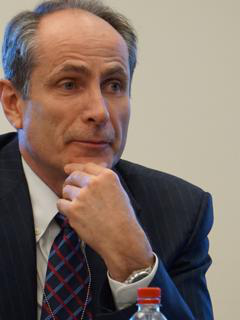

In [11]:
test_img

Для работоспособности случайных трансформаций проверим их с p=0 и с p=1, между этими наблюдениями обязательно будет разница в одну трансформацию при любом запуске. Фактически, избегаем случайности. 

In [12]:
hflip_p_0 = RandomHorizontalFlip(p=0)
erase_p_0 = RandomErasing(p=0, shape=(100, 100))
bright_p_0 = RandomAdjustBrightness(p=0, brightness_factor=0.5)

hflip_p_1 = RandomHorizontalFlip(p=1)
erase_p_1 = RandomErasing(p=1, shape=(100, 100))
bright_p_1 = RandomAdjustBrightness(p=1, brightness_factor=0.5)

img1 = Image.open('/content/people_data/train/1.jpg')
img2 = Image.open('/content/people_data/train/2.jpg')
img3 = Image.open('/content/people_data/train/3.jpg')

backgrounds = (img1, img2, img3)
repback_p_0 = RandomReplaceBackground(backgrounds, p=0)
repback_p_1 = RandomReplaceBackground(backgrounds, p=1)

to_tens = ToTensor()
norm = Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])

composed_p_0 = Compose(hflip_p_0, erase_p_0, bright_p_0, repback_p_0, to_tens, norm)
composed_p_1 = Compose(hflip_p_1, erase_p_1, bright_p_1, repback_p_1, to_tens, norm)

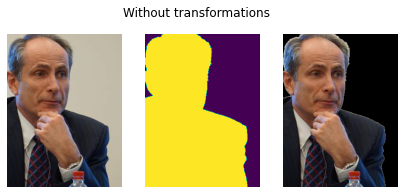

In [13]:
show_idx_image(test_sample, transform=composed_p_0)

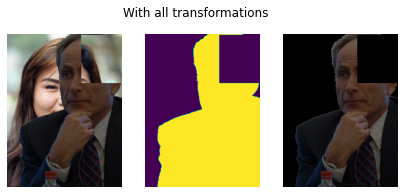

In [14]:
show_idx_image(test_sample, transform=composed_p_1, title='With all transformations')

Как видно, все нужные трансформации работают:
- случайное отображение выполняется
- случайное вырезание фрагмента работает
- случайная замена фона работает 
- случайное изменение яркости работает

Из неочевидного:
- перевод в тензор работает
- нормализация работает 

Ибо без работы этих преобразований не получилось бы отобразить результат с помощью функции ```show_idx_image```

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [15]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        logits = logits.contiguous().view(logits.shape[0], -1)
        true_labels = true_labels.contiguous().view(true_labels.shape[0], -1)

        num = torch.sum(torch.mul(logits, true_labels), dim=1)
        den = torch.sum(logits + true_labels, dim=1) + self.eps

        loss = 1 - 2 * num / den
        
        if self.reduction == 'sum':
            loss_value = loss.sum()
        elif self.reduction == 'mean':
            loss_value = loss.mean()
        elif self.reduction is None:
            loss_value = loss
            
        return loss_value

Проверка реализации:

In [17]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet (https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [18]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [19]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [20]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [21]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [22]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()

    img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor))

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)
        else:
            probs = torch.sigmoid(output)

        probs = probs.squeeze(0)

        tf = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(full_img.size[1]),
                transforms.ToTensor()
            ]
        )

        probs = tf(probs.cpu())
        full_mask = probs.squeeze().cpu().numpy()

    return full_mask > out_threshold

In [23]:
def evaluate_net(net, testloader):

    net = net.eval()
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data['image'], data['mask']
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = net(images).to(device)
            preds = (torch.sigmoid(outputs) > 0.5).type(torch.float32)
            total += labels.size(0)

            correct += (preds==labels).type(torch.float32).mean()
    
    correct = correct / total
    label = labels[0]
    pred = preds[0]
    return correct, label, pred

In [24]:
def train(net, trainloader, testloader, opt, 
              criterion, 
              num_epochs=2, verbose_num_iters=10):

    net.train()
    loss_trace = []
    correct_trace = []

    iter_i = 0
    for epoch_i in range(num_epochs):        
        for batch in trainloader:
            images, labels = batch['image'], batch['mask']
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images).to(device)
            opt.zero_grad()

            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs) > 0.5).type(torch.float32)
            correct = (preds==labels).type(torch.float32).mean()

            loss.backward()
            opt.step()

            loss_trace.append((iter_i, loss.item()))
            correct_trace.append((iter_i, correct.item()))
        
            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(22, 5))
                
                plt.subplot(1, 4, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.plot([p[0] for p in loss_trace], 
                         [p[1] for p in loss_trace])

                plt.subplot(1, 4, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Accuracy')
                plt.plot([p[0] for p in correct_trace], 
                         [p[1] for p in correct_trace], color='orange')
                    
                with torch.no_grad():
                    label = labels[0].cpu().detach().numpy()[0]
                    pred = preds[0].cpu().detach().numpy()[0] 

                    plt.subplot(1, 4, 3)
                    plt.imshow(label)
                    plt.title('true mask')
                    plt.axis('off')

                    plt.subplot(1, 4, 4)
                    plt.imshow(pred)
                    plt.title('predict mask')
                    plt.axis('off')

                plt.show()
    return loss_trace[-1][1], correct_trace[-1][1]

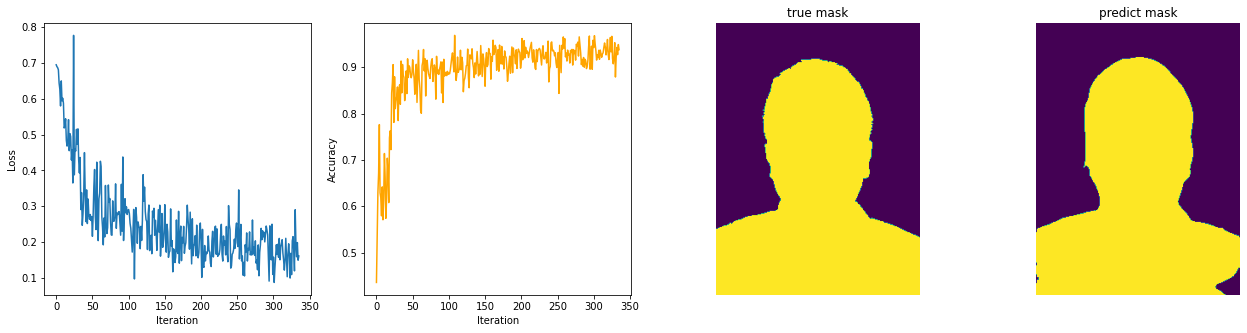

Loss: 0.216, Accuracy: 0.909


In [25]:
net = UNet().to(device)
net = nn.DataParallel(net)
opt = optim.Adam(net.parameters(), lr=1e-04)

criterion = nn.BCEWithLogitsLoss()
loss, accuracy = train(net, train_data_loader, test_data_loader, opt, criterion, verbose_num_iters=3)
print(f'Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')

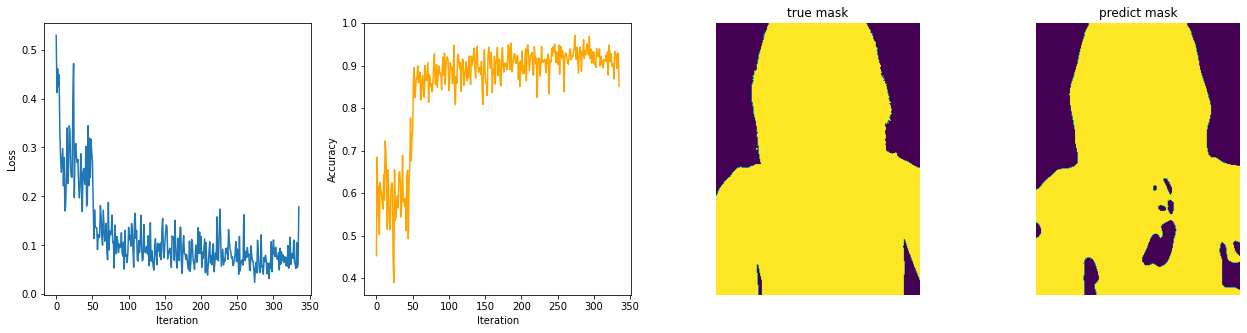

Loss: 0.033, Accuracy: 0.964


In [26]:
net = UNet().to(device)
net = nn.DataParallel(net)
opt = optim.Adam(net.parameters(), lr=1e-04)

criterion = DiceLoss(reduction='mean')
loss, accuracy = train(net, train_data_loader, test_data_loader, opt, criterion, verbose_num_iters=3)
print(f'Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')

In [27]:
class LossComposs(nn.Module):
    def __init__(self, loss1, loss2, w=(0.5, 0.5)):
        super().__init__()
        self.loss1 = loss1
        self.loss2 = loss2
        self.w = w
        
    def forward(self, logits, true_labels):
        res1 = self.loss1(logits, true_labels).float()
        res2 = self.loss2(logits, true_labels).float()
        return self.w[0]*res1 + self.w[1]*res2

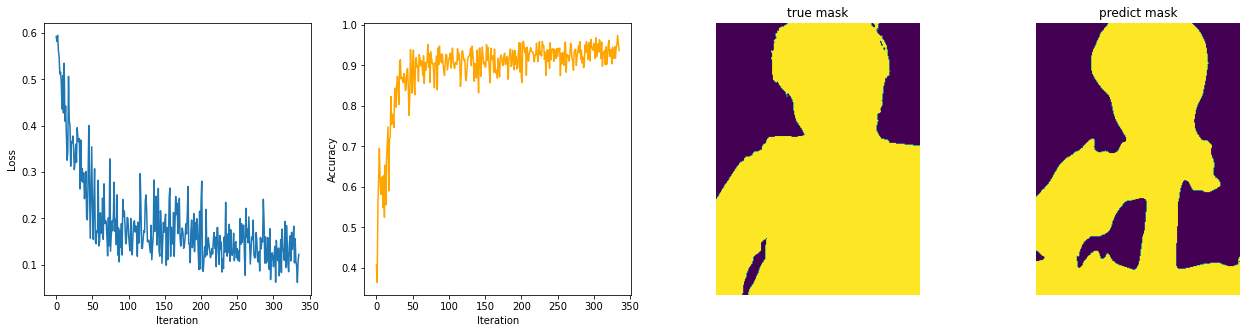

Loss: 0.113, Accuracy: 0.943


In [28]:
net = UNet().to(device)
net = nn.DataParallel(net)
opt = optim.Adam(net.parameters(), lr=1e-04)

loss1 = DiceLoss(reduction='mean')
loss2 = nn.BCEWithLogitsLoss()

criterion = LossComposs(loss1, loss2)
loss, accuracy = train(net, train_data_loader, test_data_loader, opt, criterion, verbose_num_iters=3)
print(f'Loss: {loss:.3f}, Accuracy: {accuracy:.3f}')

В целом видно, что Dice дает более хорошие результаты. Во-первых, качество в эксперименте с Dice выше, а ошибка меньше, нежели в двух других. Последний эксперимент подтверждает эту теорию, так как даже среднее между кросс-энтропией и dice loss лучше справляется с обучением, недели чистая энтропия.

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

## LinkNet (2 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

Обучите сеть и проведите анализ согласно предыдущему пункту.

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура сверточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

- Основные предположения

Свёрточные сети опираются на предположение о том, что внутри данных существуют некоторые отделимые признаки, которые могут встречаться в любой части данных. Например, кошачья мордочка может встретиться на любой части изображения или фрагмент из нескольких слов - в любой части текста. Признаки отделяются свёртками по скользящему окну, и чем больше получившаяся для элемента величина - тем сильнее окно похоже на матрицу признака в смысле скалярного произведения. Как правило, свёрточные слои объединяются со слоями пространственного объединения, позволяющими получить инвариантную относительно смещений в некоторой окрестности статистику.

Исходя из этих принципов наиболее важным можно назвать следующие два фактора:
```
1. В данных существуют важные признаки, отождествляемые с ядрами свёртки
2. Одни и те же признаки могут находится в любой части данных.
```
- Преимущества свёрток

```
1. Разреженные взаимодействия - у свёрточных сетей существенно меньше весов
2. Разделение параметров - одна и та же свёртка используется по всему изображению
3. Инвариантность относительно сдвига
```
- Когда предположения нарушаются?

Данные не имеют локальных признаков - например, задача банковского скоринга. Другой причиной не использовать свёрточные сети может быть отсутствие пространственной инвариантности внутри данных - пусть в данных важна очередность признаков: последовательность *признак_1*  -> *признак_2* может быть отличной от *признак_2* -> *признак_1*. Например, существует датасет с изображениями частей лиц, расположенных очевидно неправильно относительно друг друга для человека, на котором свёрточные сети уверенно детектируют людей.

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

- Размерность выходного пространства

Для полносвязного слоя размерность равна результату умножения матрицы на вектор:
$$
W_{1000 \times 100} \cdot x_{100\times1} = y_{1000\times1}
$$
Размерность равна 1000. 

Для свёрточной сети размерность равна произведению числа окон с учётом паддинга на число различных свёрток:
$$
(1 + 98 + 1) * 10 = 1000
$$
__Размерности выходных пространств совпадают.__

- Количество обучаемых параметров

Для полносвязной сети это число параметров в матрице $W$ - $10^5$. Поскольку по условию
$$
f(x) = \sigma(Wx)
$$
bias-ом ($b$) можно пренебречь.

Для свёрточной сети число параметров - это размер ядра свёртки на число свёрток, то есть $3 * 10 = 30$. Здесь также пренебрегааем bias-ом.

- Число операций при forward pass

Для полносвязной сети это число умножений и сложений:
$$
1000 * (100_\text{(число умножений)} + 99_\text{(число сложений)}) = 199000
$$
Для свёрточной сети:
$$
100_\text{(число признаков)} * 10_\text{(число различных свёрток)}
(3_\text{(число умножений)} + 2_\text{(число сложений)}) = 5000
$$

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

In [36]:
%%time
composed = Compose(to_tens, norm)

DATA_PATH = '/content/people_data/'

train_dataset = PhotosDataset(
      images_dir=DATA_PATH + 'train/',
      target_dir=DATA_PATH + 'train_mask/', 
      transforms=composed
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=composed
)

train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

CPU times: user 1 s, sys: 366 ms, total: 1.37 s
Wall time: 3.35 s


In [131]:
def train(net, trainloader, testloader, opt, 
              criterion, 
              num_epochs=2, verbose_num_iters=10, postproc=False):

    net.train()
    loss_trace = []
    correct_trace = []

    iter_i = 0
    for epoch_i in range(num_epochs):        
        for batch in tqdm(trainloader, desc='step'):
            images, labels = batch['image'], batch['mask']
            
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images).to(device)
            opt.zero_grad()

            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs) > 0.5).type(torch.float32)
            if postproc:
                for pred in preds:
                    pred = pred.cpu().detach().numpy()[0]
                    area_threshold = pred.sum() * 0.75
                    pred = area_opening(pred, area_threshold.astype(np.int32))

                    disk_mask = disk(min(pred.shape) // 18)
                    pred = dilation(pred, disk_mask)
                    pred = erosion(pred, disk_mask)

                    pred = pred[:, :, None]  
                    pred = torch.from_numpy(pred.astype(np.float32).transpose((2, 0, 1))).contiguous()

            label = labels[0]
            pred = preds[0]

            correct = (preds==labels).type(torch.float32).mean()
            loss.backward()
            opt.step()

            loss_trace.append((iter_i, loss.item()))
            correct_trace.append((iter_i, correct.item()))
        
            iter_i += 1

    return loss_trace, correct_trace, label, pred

In [137]:
net = UNet().to(device)
net = nn.DataParallel(net)
opt = optim.Adam(net.parameters(), lr=1e-04)

criterion = nn.BCEWithLogitsLoss()
loss1, accuracy1, label1, pred1 = train(net, test_data_loader, test_data_loader, opt, criterion, verbose_num_iters=3)

In [133]:
net = UNet().to(device)
net = nn.DataParallel(net)
opt = optim.Adam(net.parameters(), lr=1e-04)

criterion = nn.BCEWithLogitsLoss()
loss2, accuracy2, label2, pred2 = train(net, test_data_loader, test_data_loader, opt, criterion, verbose_num_iters=3, postproc=True)

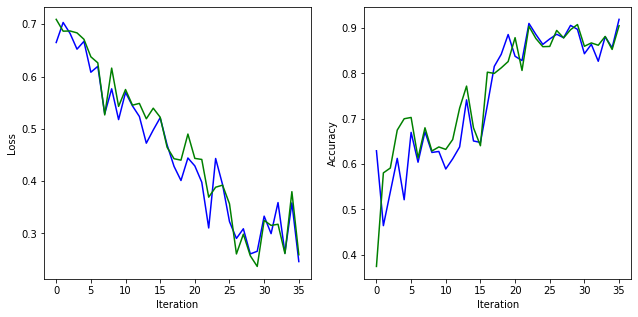

In [138]:
plt.figure(figsize=(22, 5))
                
plt.subplot(1, 4, 1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot([p[0] for p in loss1], [p[1] for p in loss1], color='blue', label='without preprocessing')
plt.plot([p[0] for p in loss2], [p[1] for p in loss2], color='green', label='with preprocessing')


plt.subplot(1, 4, 2)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.plot([p[0] for p in accuracy1], [p[1] for p in accuracy1], color='blue', label='without preprocessing')
plt.plot([p[0] for p in accuracy2], [p[1] for p in accuracy2], color='green', label='with preprocessing')

Как видно, качество незначительно, но улучшилось.
Проверим на изображениях:


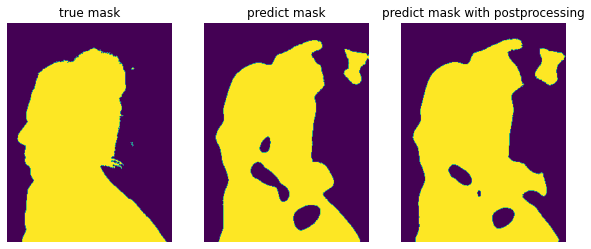

In [139]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.title('true mask')
plt.imshow(label1.cpu().detach().numpy()[0])

plt.subplot(1, 3, 2)
plt.axis('off')
plt.title('predict mask')
plt.imshow(pred1.cpu().detach().numpy()[0])

plt.subplot(1, 3, 3)
plt.axis('off')
plt.title('predict mask with postprocessing')
plt.imshow(pred2.cpu().detach().numpy()[0])

plt.show()

В целом стало лучше за счет исключения "островков" и "дырок".

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: catalyst, pytorch-lightning, kekas.